# Approximating derivatives
In this workbook, we'll see a few ideas for doing derivative computations. You'll see more on the homework. 

## Automatic differentiation
The first type of derivative computation is a source code transform. This is called automatic differentiation, and consists of taking in a program and outputing a program. We won't talk too much about this idea, but it's used frequently in optimization. Purdue Prof. Alex Pothen is currently doing research on these ideas.  

Julia has a package to do this (actually, a few).

In [9]:
using Pkg
Pkg.add("ReverseDiff")
using ReverseDiff
using Plots
using Interact

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [13]:
using ReverseDiff: gradient
myf(x,y) = (1.0.-x).^2 + 100(y.-x.^2).^2
gradient(myf, ([3.0],[5.0]))

([4804.0], [-800.0])

In [15]:
myf2(x,y) = sin(x).*(1.0.-x).^2 + 100(y.-x.^2).^2
gradient(myf2, ([3.0],[5.0]))

([4796.604510045838], [-800.0])

In [19]:
sin.([5.0])

1-element Array{Float64,1}:
 -0.9589242746631385

In [20]:
@show gradient(myf, ([-1.0],[0.0]))
@show gradient(myf, ([1.0],[0.0]))
@show gradient(myf, ([0.0],[-1.0]))
@show gradient(myf, ([0.0],[1.0]))
    ;

gradient(myf, ([-1.0], [0.0])) = ([-404.0], [-200.0])
gradient(myf, ([1.0], [0.0])) = ([400.0], [-200.0])
gradient(myf, ([0.0], [-1.0])) = ([-2.0], [-200.0])
gradient(myf, ([0.0], [1.0])) = ([-2.0], [200.0])


In [21]:
using ReverseDiff: hessian
myf(x,y) = (1.0.-x).^2 + 100(y.-x.^2).^2
hessian(myf, ([1.0],[1.0]))

LoadError: Taking the Hessian of a function with multiple arguments is not yet supported

In [22]:
myf1(x) = (1.0.-x[1]).^2 + 100(x[2].-x[1].^2).^2
hessian(myf1, ([1.0,1.0]))

2×2 Array{Float64,2}:
  802.0  -400.0
 -400.0   200.0

In [7]:
# There is a more efficient way to use these same ideas too. It involves a little more setup. 
using ReverseDiff: GradientTape, compile
# this just needs the same. 
const myf_tape = GradientTape(myf, (rand(1), rand(1)))


# compile `f_tape` into a more optimized representation
const compiled_myf_tape = compile(myf_tape)

ReverseDiff.CompiledTape(myf)

In [10]:
using ReverseDiff: gradient!
gradient!(([1.0],[2.0]), compiled_myf_tape, ([1.0],[1.0]))

([0.0], [0.0])

In [17]:
#= 
more generally, this gives you a way to _allocate_ the output a head of time. This is important for performance because you don't want to be creating and deleting memory all the time. (Allocating and dealing with memory is a _fast_ operation, but is slower than pure arithmetic.)
=#
output = (randn(1),randn(1))
input = ([0.0],[1.0])
gradient!(output, compiled_myf_tape, input)

([-2.0], [200.0])

In [18]:
# We can 'reuse' output. 
output = (randn(1),randn(1))
input = ([0.0],[1.0])
map( x->gradient!(output, compiled_myf_tape, x), [([0.0],[1.0]),([0.0],[-1.0])])

2-element Array{Tuple{Array{Float64,1},Array{Float64,1}},1}:
 ([-2.0], [-200.0])
 ([-2.0], [-200.0])

In [20]:
# What goes wrong here? That isn't right! It's our 'reuse' of output. We are storing 2 pointers to the output!

map( x-> println(gradient!(output, compiled_myf_tape, x)), [([0.0],[1.0]),([0.0],[-1.0])])

([-2.0], [200.0])
([-2.0], [-200.0])


2-element Array{Nothing,1}:
 nothing
 nothing

In [16]:
# But these compiled versions are specific to the sizes! 
using ReverseDiff: gradient!
gradient!(([0.0,0.0],[0.0,0.0]), compiled_myf_tape, ([1.0,2.0],[1.0,3.0]))

LoadError: MethodError: no method matching iterate(::ReverseDiff.CompiledTape{GradientTape{typeof(myf),Tuple{ReverseDiff.TrackedArray{Float64,Float64,1,Array{Float64,1},Array{Float64,1}},ReverseDiff.TrackedArray{Float64,Float64,1,Array{Float64,1},Array{Float64,1}}},ReverseDiff.TrackedArray{Float64,Float64,1,Array{Float64,1},Array{Float64,1}}}})
Closest candidates are:
  iterate(!Matched::Plots.SegmentsIterator) at /Users/dgleich/.julia/packages/Plots/ViMfq/src/utils.jl:100
  iterate(!Matched::Plots.SegmentsIterator, !Matched::Int64) at /Users/dgleich/.julia/packages/Plots/ViMfq/src/utils.jl:100
  iterate(!Matched::Base.MethodList, !Matched::Any...) at reflection.jl:871
  ...

In [5]:
Pkg.add("XGrad")
using XGrad

  Resolving package versions...
  Installed XGrad ──── v0.2.0
  Installed Espresso ─ v0.6.1
Updating `~/.julia/environments/v1.5/Project.toml`
  [c48004fe] + XGrad v0.2.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [6912e4f1] + Espresso v0.6.1
  [c48004fe] + XGrad v0.2.0
┌ Info: Precompiling XGrad [c48004fe-d13f-5df9-98d5-0c1ab8e45fa0]
└ @ Base loading.jl:1278


In [4]:

xdiff( :(exp(x^2)*(sin(100x)^2)) , x=1.)


LoadError: UndefVarError: xdiff not defined

You should be able to directly evaluate these functions, but I couldn't get that working before class. 

In [32]:
# This should work, but as of 2016-02-23, it doesn't :(
# rosenbrock(x) = (1 - x[1])^2 + 100(x[2] - x[1]^2)^2
# rdiff( rosenbrock , x=ones(2))  # 'x=2.' indicates the type of x to rdiff

rosenbrock(x,y) = (1 - x)^2 + 100(y - x^2)^2
drosen = xdiff(rosenbrock; x=1.,y=1.)  




LoadError: MethodError: no method matching getproperty(::Module, ::Expr)
Closest candidates are:
  getproperty(::Module, !Matched::Symbol) at Base.jl:26
  getproperty(::Any, !Matched::Symbol) at Base.jl:33

## Finite differences
We can also use a finite difference approximation. The idea is that the derivative is formally 
$$ f'(x) = \lim_{h\to 0} \frac{f(x+h) - f(x)}{h} $$
and so we should be able to get a good approximation by using
$$ f'(x) \approx \frac{f(x+h) - f(x)}{h} $$
with $h$ very small


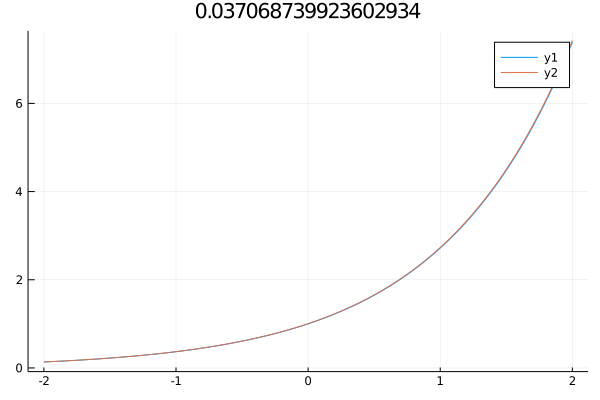

In [23]:
using Plots
using LinearAlgebra
h = 0.01
expderiv(x) = (exp.(x+h)-exp.(x))./h
xx = collect(range(-2,stop=2,length=1000))
plot(xx,exp.(xx))
plot!(xx,expderiv.(xx))
title!(string(norm(exp.(xx) - expderiv.(xx),Inf)))

In [24]:
using Blink,Interact
ui = @manipulate for h=collect(10 .^ range(-16,stop=-1,length=16))
    expderiv(x) = (exp.(x+h)-exp.(x))./h
    xx = collect(range(-2,stop=2,length=1000))
    plot(xx,exp.(xx))
    plot!(xx,expderiv.(xx))
    title!(string(norm(exp.(xx) - expderiv.(xx),Inf)))
end
w = Window()
body!(w,ui)

Page(3, WebSocket(server, CONNECTED), Dict{String,Any}("webio" => Blink.AtomShell.var"#24#25"{Blink.AtomShell.WebIOBlinkComm}(Blink.AtomShell.WebIOBlinkComm(Window(3, Electron(Process(`/Users/dgleich/.julia/packages/Blink/u1xcH/deps/Julia.app/Contents/MacOS/Julia /Users/dgleich/.julia/packages/Blink/u1xcH/src/AtomShell/main.js port 5334`, ProcessRunning), Sockets.TCPSocket(RawFD(0x0000003a) active, 0 bytes waiting), Dict{String,Any}("callback" => Blink.var"#1#2"())), Page(#= circular reference @-5 =#), Task (done) @0x000000012fc36890))),"callback" => Blink.var"#1#2"()), Distributed.Future(1, 1, 3, Some(true)))

Unexpected end of input
 ...when parsing byte with value '0'
Stacktrace:
 [1] error(::String) at ./error.jl:33
 [2] _error(::String, ::JSON.Parser.StreamingParserState{Sockets.TCPSocket}) at /Users/dgleich/.julia/packages/JSON/d89fA/src/Parser.jl:150
 [3] byteat(::JSON.Parser.StreamingParserState{Sockets.TCPSocket}) at /Users/dgleich/.julia/packages/JSON/d89fA/src/Parser.jl:59
 [4] current at /Users/dgleich/.julia/packages/JSON/d89fA/src/Parser.jl:72 [inlined]
 [5] chomp_space! at /Users/dgleich/.julia/packages/JSON/d89fA/src/Parser.jl:117 [inlined]
 [6] parse_value(::JSON.Parser.ParserContext{Dict{String,Any},Int64,true,nothing}, ::JSON.Parser.StreamingParserState{Sockets.TCPSocket}) at /Users/dgleich/.julia/packages/JSON/d89fA/src/Parser.jl:160
 [7] parse(::Sockets.TCPSocket; dicttype::Type{T} where T, inttype::Type{Int64}, allownan::Bool, null::Nothing) at /Users/dgleich/.julia/packages/JSON/d89fA/src/Parser.jl:494
 [8] parse at /Users/dgleich/.julia/packages/JSON/d89fA/src/Parser.j